# 하이퍼 파라미터 튜닝을 위한 함수정의 및 평가


In [41]:
# !pip install numpy
# !pip install pandas
# !pip install rdkit
# !pip install scikit-learn

In [42]:
import numpy as np
import pandas as pd
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
import sklearn.metrics as metrics
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Data

Let's load the compound data file.

In [43]:
cmpd_df = pd.read_csv('cmpd.csv')
cmpd_df.head()

,inchikey,smiles,group,activity
0,FNHKPVJBJVTLMP-UHFFFAOYSA-N,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,train,active
1,CUDVHEFYRIWYQD-UHFFFAOYSA-N,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,train,active
2,TTZSNFLLYPYKIL-UHFFFAOYSA-N,Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...,test,active
3,UOVCGJXDGOGOCZ-UHFFFAOYSA-N,COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2,train,active
4,CUIHSIWYWATEQL-UHFFFAOYSA-N,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,test,active


In [44]:
cmpd_df.shape

(5530, 4)

There are 5530 compound samples with:
* SMILES - 2D compound structure,
* InChIKey - a hash from InChI,
* group - a tag to split the dataset into train and test
* activity - y label

In [45]:
cmpd_df['mol'] = cmpd_df.smiles.apply(Chem.MolFromSmiles)

In [46]:
# with minimal modification, we obtain the fingerprint vector using RDKit

def get_Xy(df):
    X = np.vstack(df.mol.apply(lambda m: list(AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits=2048))))
    y = df.activity.eq('active').astype(float).to_numpy()
    return X, y

In [47]:
X_train, y_train = get_Xy(cmpd_df[cmpd_df.group.eq('train')])
X_test, y_test = get_Xy(cmpd_df[cmpd_df.group.eq('test')])

## Hyper Parameter Tuning


1. 과적합 방지를 위한 하이퍼 파라미터 튜닝 함수 정의

In [48]:
# 기본 모델링 함수
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(x_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(x_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(x_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before

# 하이퍼 파라미터별 모델 성능 시각화 함수
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    # plt.savefig('./figure/' + algorithm_name + '_' + filename + '.png') # 시각화한 그래프는 로컬에 저장


    
# 모델 최적화 함수 : 학습할 트리 모델 개수 선정
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))


# 모델 최적화 함수 : 최대 깊이 선정
def optimi_maxdepth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))

# 모델 최적화 함수 : 분리 노드의 최소 자료 수 선정
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))

# 모델 최적화 함 수 : 잎사귀 노드의 최소 자료 수 선정
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))


# 최종 모델 학습
def model_final(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator, n_depth, n_split, n_leaf):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링  
    model = algorithm(random_state = 1234, 
                        n_estimators = n_estimator, 
                        min_samples_leaf = n_leaf,
                        min_samples_split = n_split, 
                        max_depth = n_depth)
    # 모델 학습
    model.fit(x_train, y_train)
        
    # 최종 모델의 성능 평가
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
    print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
    print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어


2. 과적합 확인을 위한 학습 데이터셋 정확도 및 테스트 데이터 셋 정확도 측정

In [49]:
# 1) 과적합 확인을 위한 학습 데이터셋 정확도 및 테스트 데이터 셋 정확도 측정

algorithm = RFC
algorithm_name = 'rfc'

train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          X_train,
                                                          y_train,
                                                          X_test,
                                                          y_test)

학습 데이터셋 정확도: 0.996
테스트 데이터셋 정확도: 0.876


3. 모델 최적화를 위해 학습할 트리 개수 선정 

    n_estimators  TrainScore  TestScore
0              5      0.9776     0.7630
1             10      0.9897     0.8216
2             15      0.9940     0.8274
3             20      0.9932     0.8442
4             25      0.9952     0.8506
5             30      0.9955     0.8571
6             35      0.9962     0.8571
7             40      0.9962     0.8641
8             45      0.9965     0.8628
9             50      0.9965     0.8622
10            55      0.9965     0.8616
11            60      0.9965     0.8661
12            65      0.9965     0.8725
13            70      0.9965     0.8712
14            75      0.9965     0.8674
15            80      0.9965     0.8699
16            85      0.9965     0.8706
17            90      0.9965     0.8719
18            95      0.9965     0.8777
19           100      0.9965     0.8757
20           105      0.9965     0.8725
21           110      0.9965     0.8706
22           115      0.9965     0.8744
23           120      0.9965     0.8738


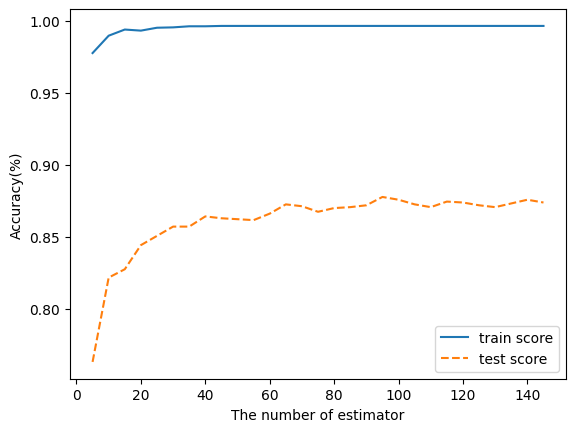

In [60]:
# 최소 및 최대 값
n_estimator_min = 10
n_estimator_max = 31

optimi_estimator(algorithm, algorithm_name, 
                 X_train, y_train, X_test, y_test, 
                 n_estimator_min, n_estimator_max)

4. 모델 최적화를 위해 최대 깊이 선정


    depth  TrainScore  TestScore
0      10      0.8627     0.8120
1      11      0.8720     0.8300
2      12      0.8866     0.8294
3      13      0.8969     0.8242
4      14      0.9080     0.8390
5      15      0.9185     0.8506
6      16      0.9210     0.8487
7      17      0.9293     0.8461
8      18      0.9354     0.8513
9      19      0.9427     0.8558
10     20      0.9474     0.8590
11     21      0.9492     0.8448
12     22      0.9547     0.8480
13     23      0.9578     0.8545
14     24      0.9615     0.8429


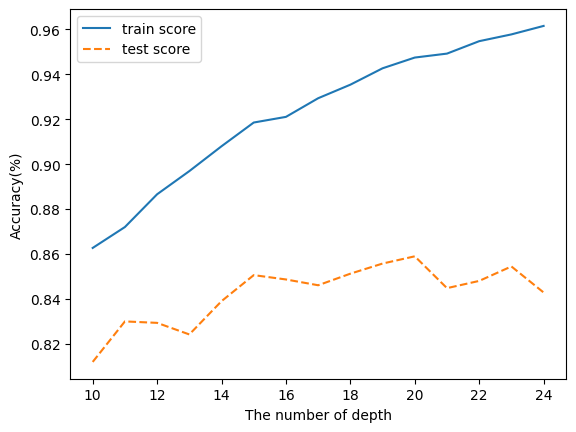

In [61]:
n_estimator = 30                 
depth_min = 10
depth_max = 25
optimi_maxdepth(algorithm, algorithm_name, 
                X_train, y_train, X_test, y_test, 
                depth_min, depth_max, n_estimator)

5. 분리 노드의 최소 자료 수 선정


    min_samples_split  TrainScore  TestScore
0                  20      0.9150     0.8506
1                  22      0.9120     0.8435
2                  24      0.9120     0.8493
3                  26      0.9097     0.8461
4                  28      0.9065     0.8474
5                  30      0.9077     0.8345
6                  32      0.9012     0.8500
7                  34      0.8997     0.8429
8                  36      0.9002     0.8274
9                  38      0.9004     0.8448
10                 40      0.8999     0.8474
11                 42      0.8997     0.8435
12                 44      0.8984     0.8364
13                 46      0.8944     0.8448
14                 48      0.8909     0.8339
15                 50      0.8916     0.8403
16                 52      0.8863     0.8358
17                 54      0.8874     0.8410
18                 56      0.8886     0.8455
19                 58      0.8843     0.8519
20                 60      0.8904     0.8410
21        

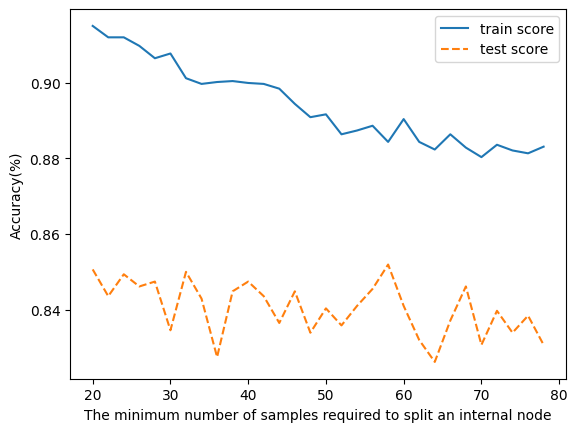

In [62]:
n_depth = 20 
n_split_min = 10
n_split_max = 40
 
pd.set_option('display.max_row', 100)
optimi_minsplit (algorithm, algorithm_name,
                 X_train, y_train, X_test, y_test,
                 n_split_min, n_split_max, n_estimator, n_depth)

6. 잎사귀 노드의 최소 자료 수 선정

   min_samples_leaf  TrainScore  TestScore
0                 2      0.9042     0.8474
1                 4      0.8858     0.8525
2                 6      0.8763     0.8210
3                 8      0.8685     0.8300
4                10      0.8599     0.8171
5                12      0.8584     0.8197
6                14      0.8589     0.8146
7                16      0.8564     0.8236
8                18      0.8547     0.8307


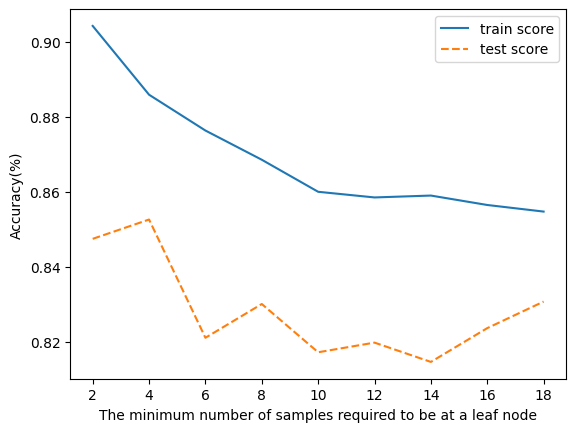

In [63]:
n_split = 20  
n_leaf_min = 1
n_leaf_max = 10
optimi_minleaf(algorithm, algorithm_name, 
               X_train, y_train, X_test, y_test, 
               n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

In [64]:
n_leaf = 3

model_final(algorithm, algorithm_name, 
            X_train, y_train, X_test, y_test,
            n_estimator, n_depth, n_split, n_leaf)

Accuracy: 0.848
Precision: 0.869
Recall: 0.679
F1-score: 0.763


In [55]:

clf = RandomForestClassifier(n_estimators = n_estimator, max_depth = n_depth, min_samples_leaf = n_leaf, min_samples_split = n_split)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.7533805537669027

In [56]:
y_pred = clf.predict_proba(X_test)[:, 1]

In [57]:
# logloss
metrics.log_loss(y_test, y_pred, labels=[0, 1])

0.5557254895535539

In [58]:
# AUC PRC
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred, pos_label=1)
metrics.auc(recall, precision)

0.7470123167053331

In [59]:
# AUC ROC
fpr_roc, tpr_roc, _ = metrics.roc_curve(y_test, y_pred, pos_label=1)
metrics.auc(fpr_roc, tpr_roc)

0.8078276688099999